<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/AE_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Auto-Encoder


In [39]:
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision
import torch.utils as utils

seed = 100
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [40]:
# Read CIFAR-10 data and convert each image to grayscale for input
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, path, transform1 = None, transform2 = None, train = True):
        self.transform1 = torchvision.transforms.ToTensor()
        self.transform2 = torchvision.transforms.Compose([torchvision.transforms.Grayscale(), torchvision.transforms.ToTensor()])
        self.train = train

        self.labelset = torchvision.datasets.CIFAR10(root = path, train = self.train, download = True)
        self.dataset = torchvision.datasets.CIFAR10(root = path, train = self.train, download = True)

        self.datanum = len(self.dataset)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_label = self.labelset[idx][0]
        out_data = self.dataset[idx][0]

        if self.transform1:
            out_label = self.transform1(out_label)

        if self.transform2:
            out_data = self.transform1(out_data)

        return out_data, out_label

In [41]:
# Load Data
dataset = Mydatasets('./data', train=True)
print(dataset[0][0].shape)
print(dataset[0][1].shape)

batch_size = 16

dataloader_train = utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)


Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


In [42]:
import torch.nn as nn


# make tensor.view() Module to use it in Sequential
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    def forward(self,x):
        return x.view(self.shape)

In [43]:
# Network

class CNV_AE(nn.Module):
  def __init__(self):
    super(CNV_AE, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
        nn.Tanh(),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.Tanh(),
    )
#    self.conv3 = nn.Sequential(
#        nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
#        nn.Tanh(),
#    )
    self.lin1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(8*8*32, 512),
        nn.Softmax(dim=1),
    )
    self.lin2 = nn.Sequential(
        nn.Linear(512, 8*8*32),
        Reshape(-1, 32, 8, 8),
    )
#    self.deconv1 = nn.Sequential(
#        nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
#        nn.Tanh(),
#    )
    self.deconv2 = nn.Sequential(
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Tanh(),
    )
    self.deconv3 =nn.Sequential(
        nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid(),
    )
  def forward(self, x1):
    x2 = self.conv1(x1)
    x3 = self.conv2(x2)
#    x4 = self.conv3(x3)
    z1 = self.lin1(x3)
    z2 = self.lin2(z1)
#    x5 = self.deconv1(z2)
    x6 = self.deconv2(z2)
    y  = self.deconv3(x6)
    return y

In [44]:
# Define model
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNV_AE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

print(model)

CNV_AE(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
  (lin1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=512, bias=True)
    (2): Softmax(dim=1)
  )
  (lin2): Sequential(
    (0): Linear(in_features=512, out_features=2048, bias=True)
    (1): Reshape()
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): Tanh()
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): Sigmoid()
  )
)


In [45]:
# Training
nepoch = 100

for i in range(nepoch):
  print(f"EPOCH: {i+1}")

  ### Train ###
  model.train()
  for x, t in dataloader_train:
    x = x.to(device)
    t = t.to(device)
    model.zero_grad()
    y = model(x)
    loss = criterion(y, t)
    loss.backward()
    optimizer.step()

  model.eval()
  sum_loss = 0.0
  sum_iter = 0
  for x, t in dataloader_train:
    x = x.to(device)
    t = t.to(device)
    y = model(x)
    loss = criterion(y, t)
    sum_loss += loss.cpu().detach().numpy()
    sum_iter += 1
  print(f"  train loss: {sum_loss/sum_iter}")


EPOCH: 1
  train loss: 0.04470138792157173
EPOCH: 2
  train loss: 0.044431265711188314
EPOCH: 3
  train loss: 0.044218161547780035
EPOCH: 4
  train loss: 0.037752623908519745
EPOCH: 5
  train loss: 0.037798226770162584
EPOCH: 6
  train loss: 0.03741142468631267
EPOCH: 7
  train loss: 0.03749120450139046
EPOCH: 8
  train loss: 0.03733896632909775
EPOCH: 9
  train loss: 0.03741353256881237
EPOCH: 10
  train loss: 0.03409552321135998
EPOCH: 11
  train loss: 0.03348393790781498
EPOCH: 12
  train loss: 0.033360376213788984
EPOCH: 13
  train loss: 0.03327181139409542
EPOCH: 14
  train loss: 0.033257096658945086
EPOCH: 15
  train loss: 0.03327819368064404
EPOCH: 16
  train loss: 0.0331517763108015
EPOCH: 17
  train loss: 0.03319368660390377
EPOCH: 18
  train loss: 0.033174483095407485
EPOCH: 19
  train loss: 0.03308746323525905
EPOCH: 20
  train loss: 0.03307867538690567
EPOCH: 21
  train loss: 0.033096508369445804
EPOCH: 22
  train loss: 0.03308119733393192
EPOCH: 23
  train loss: 0.03303288

torch.Size([16, 3, 32, 32])
(32, 32, 3)


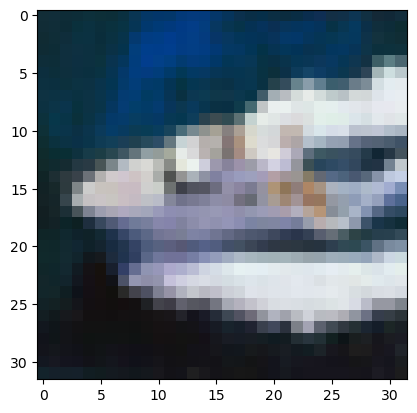

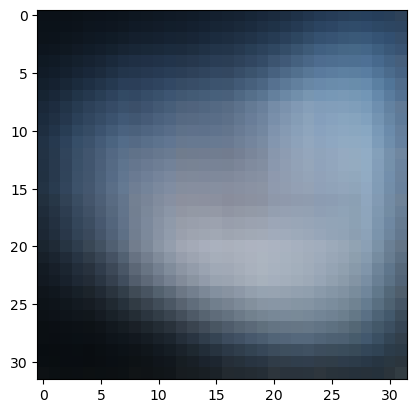


(32, 32, 3)


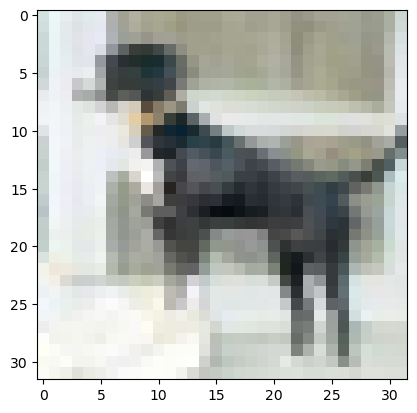

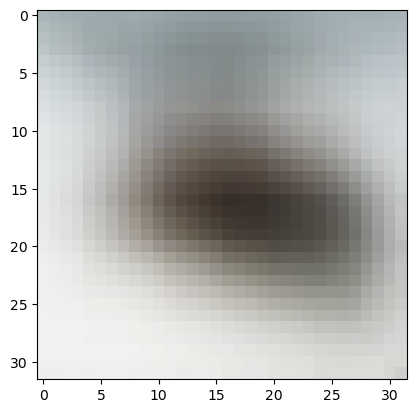


(32, 32, 3)


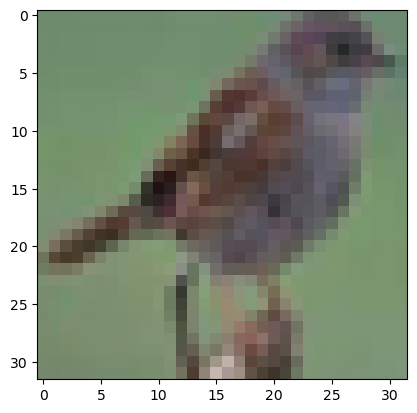

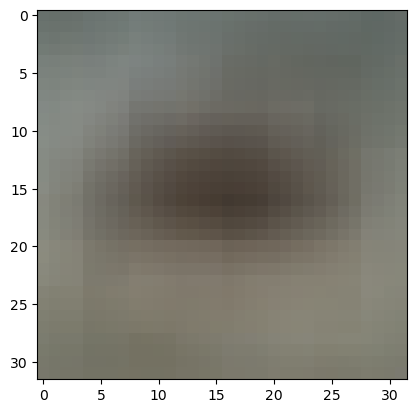


(32, 32, 3)


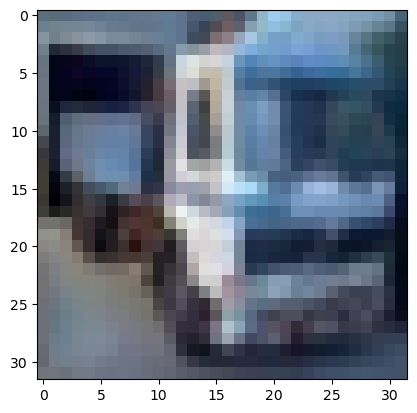

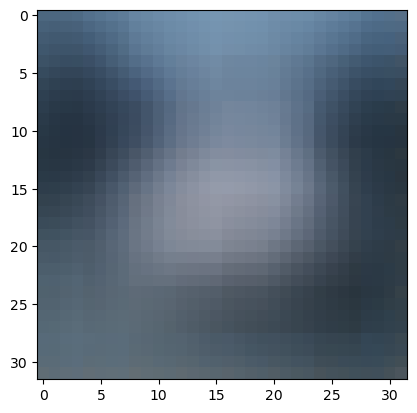


(32, 32, 3)


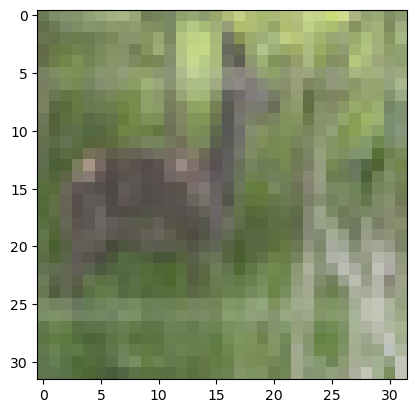

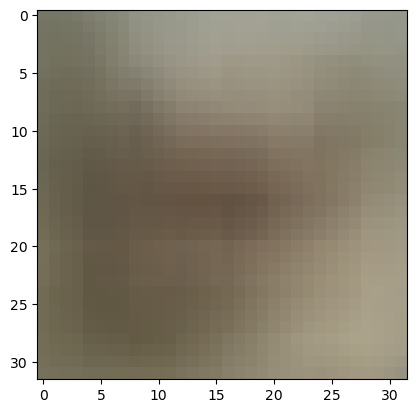


(32, 32, 3)


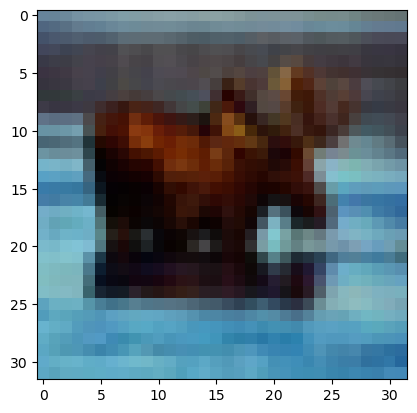

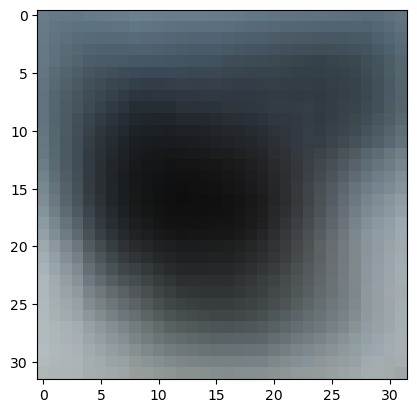


(32, 32, 3)


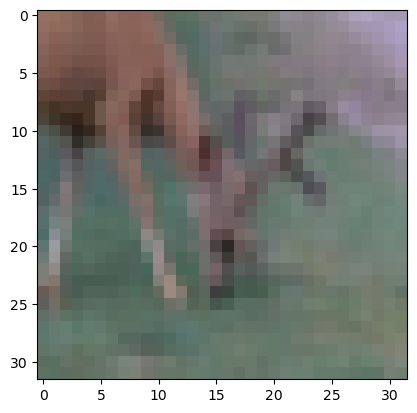

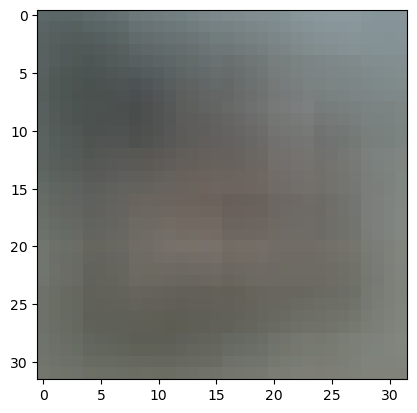


(32, 32, 3)


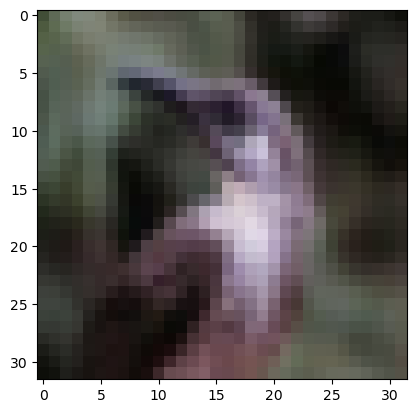

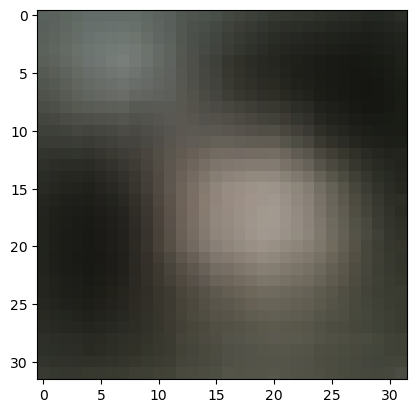


(32, 32, 3)


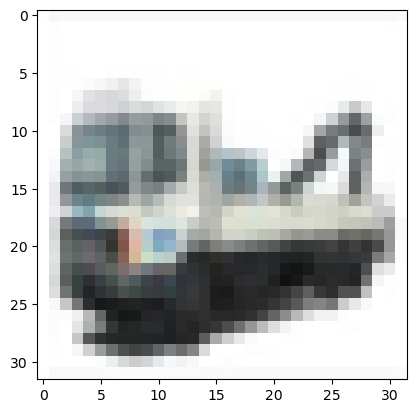

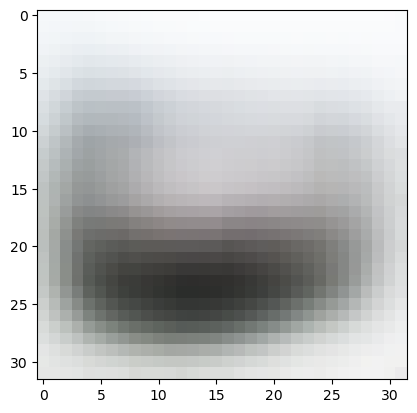


(32, 32, 3)


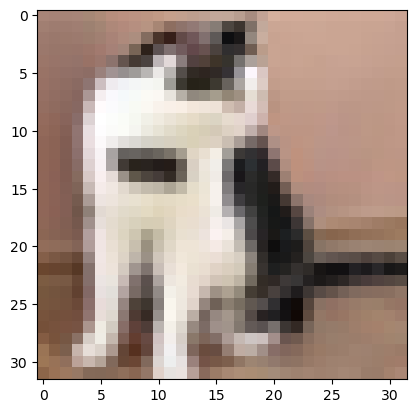

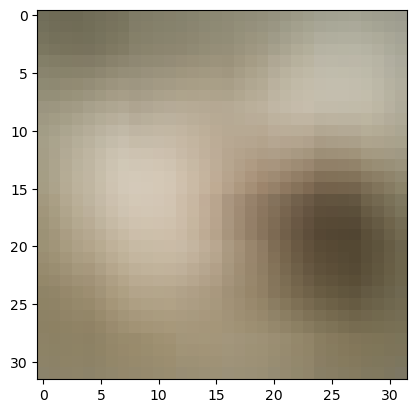


(32, 32, 3)


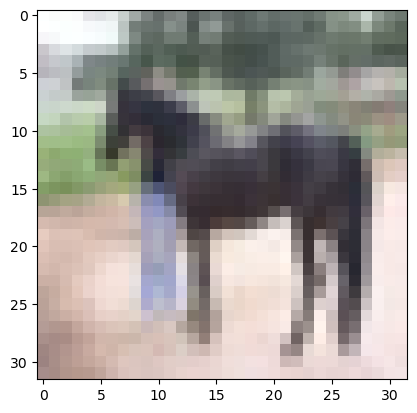

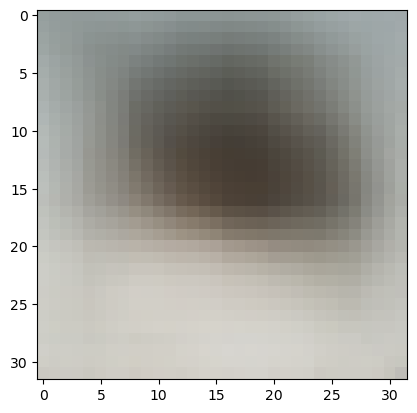


(32, 32, 3)


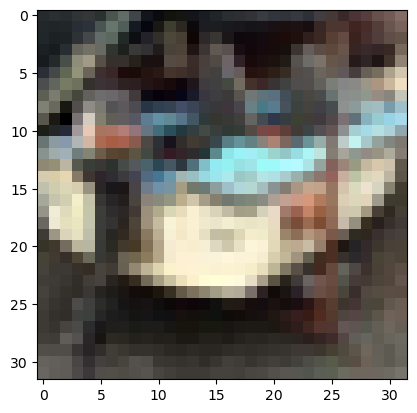

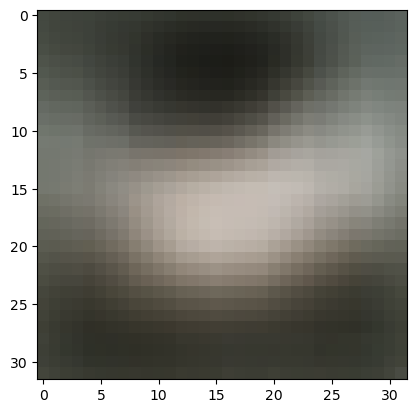


(32, 32, 3)


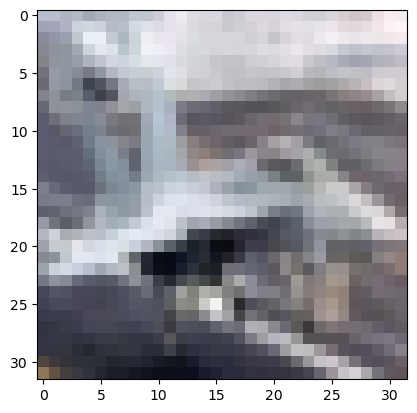

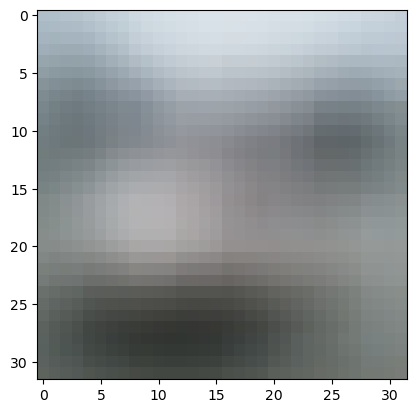


(32, 32, 3)


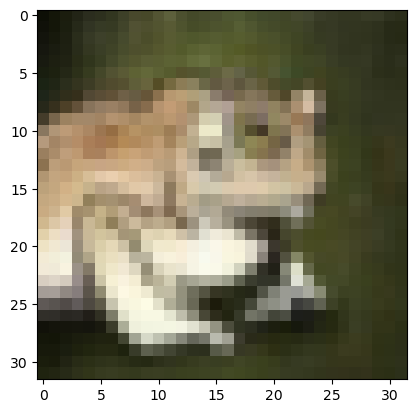

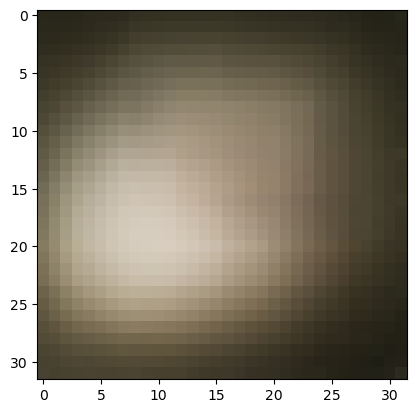


(32, 32, 3)


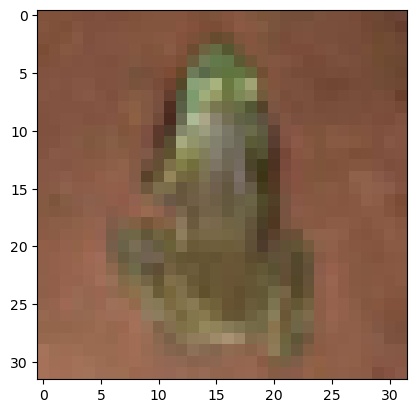

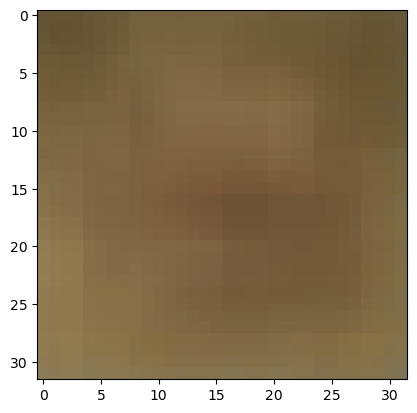


(32, 32, 3)


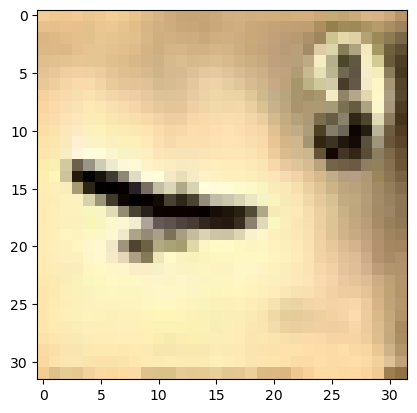

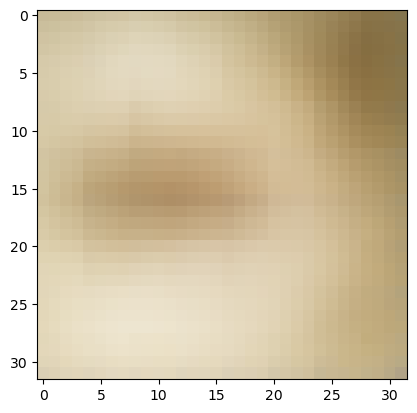

In [46]:
# Visualization

import matplotlib.pyplot as plt
%matplotlib inline

model.eval()
for x, t in dataloader_train:
    print(x.shape)
    x = x.to(device)
    y = model(x)
    for i in range(len(t)):
        yimg = y[i].cpu().permute(1,2,0).detach().numpy()
        print(yimg.shape)
        timg = t[i].permute(1,2,0).detach().numpy()
        plt.imshow(timg)
        plt.show()
        plt.imshow(yimg)
        plt.show()
        print("\n =================== ")

    break